# Train Best Models for each Dataset

In [1]:
from sklearn.model_selection import train_test_split
import numpy as np

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
import torch.optim as optim
import torch
from sklearn.metrics import f1_score, recall_score, accuracy_score, precision_score
#area under the curve
from sklearn.metrics import roc_auc_score
import numpy as np



class GNN(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(num_node_features, 16)
        self.conv2 = GCNConv(16, num_classes)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        # Remove sigmoid here because BCEWithLogitsLoss applies it internally
        x = global_mean_pool(x, batch)  # Aggregate node features to graph-level features
        return x



    

c:\Users\Lenovo\anaconda3\envs\thesis\Lib\site-packages\torch_geometric\typing.py:63: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
c:\Users\Lenovo\anaconda3\envs\thesis\Lib\site-packages\torch_geometric\typing.py:90: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(
c:\Users\Lenovo\anaconda3\envs\thesis\Lib\site-packages\torch_geometric\typing.py:101: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


In [2]:
import glob
datasets=glob.glob('./Seperated_dataset/*')
datasets

['./Seperated_dataset\\nr-ahr',
 './Seperated_dataset\\nr-ar',
 './Seperated_dataset\\nr-ar-lbd',
 './Seperated_dataset\\nr-aromatase',
 './Seperated_dataset\\nr-er',
 './Seperated_dataset\\nr-er-lbd',
 './Seperated_dataset\\nr-ppar-gamma',
 './Seperated_dataset\\sr-are',
 './Seperated_dataset\\sr-atad5',
 './Seperated_dataset\\sr-hse',
 './Seperated_dataset\\sr-mmp',
 './Seperated_dataset\\sr-p53']

In [55]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
import torch.optim as optim


class GNN(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(num_node_features, 16)
        self.conv2 = GCNConv(16, num_classes)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        # Remove sigmoid here because BCEWithLogitsLoss applies it internally
        x = global_mean_pool(x, batch)  # Aggregate node features to graph-level features
        return x

dataset=datasets[0]
train_data=torch.load(dataset+'/train_feature.pt')
train_label=torch.load(dataset+'/train_labels.pt')



data_list=train_data
labels_array=np.array(train_label)


#remove the graphs and labels that has the graph as None. Remember to remove the None from the labels as well. labels are not None, rather the graph is None

graphs_no_none=[]
labels_no_none=[]
for graph,label in zip(data_list,labels_array):
    if(graph!=None):
        graphs_no_none.append(graph)
        labels_no_none.append(label)
    

data_list=graphs_no_none
labels_array=np.array(labels_no_none)



i=0
for graph,label in zip(data_list,labels_array):
    # print(i)
    i+=1
    graph.y = torch.tensor(label, dtype=torch.float).view(1, -1)

# Split the indices of our dataset into training and validation sets
train_indices, val_indices = train_test_split(np.arange(len(data_list)),
                                            test_size=0.1,  # 20% for validation
                                            stratify=labels_array,  # Preserve class distribution
                                            random_state=42)
# print(labels_array)

# Create training and validation sets using the split indices
train_data_list = [data_list[i] for i in train_indices]
train_labels_array = labels_array[train_indices]

val_data_list = [data_list[i] for i in val_indices]
val_labels_array = labels_array[val_indices]


train_loader = DataLoader(train_data_list, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data_list, batch_size=32, shuffle=False)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNN(num_node_features=20, num_classes=1).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = torch.nn.BCEWithLogitsLoss()


In [56]:
print(dataset)

./Seperated_dataset\nr-ahr


In [57]:
import torch
from sklearn.metrics import f1_score, recall_score, accuracy_score, precision_score
#area under the curve
from sklearn.metrics import roc_auc_score
import numpy as np

num_epochs = 100
best_val_auc = float('-inf')  # Initialize with the lowest possible value
best_model_path = dataset+'/best_model.pt'
print(best_model_path)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    all_labels = []
    all_predictions = []

    # Training phase
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = loss_func(out, data.y.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs

        preds = torch.round(torch.sigmoid(out))
        correct_predictions += (preds == data.y.float()).sum().item()
        total_predictions += data.y.size(0)

        all_labels.extend(data.y.tolist())
        # Check if preds.squeeze().tolist() is not a list and then extend
        preds_list = preds.squeeze().tolist()
        if isinstance(preds_list, float):  # This means there's only one prediction
            all_predictions.append(preds_list)  # Append the single prediction
        else:
            all_predictions.extend(preds_list)  # Extend the list of predictions

    train_accuracy = correct_predictions / total_predictions
    train_avg_loss = total_loss / len(train_loader.dataset)
    # print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_avg_loss:.9f}, Train Accuracy: {train_accuracy:.4f}')

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        val_loss = 0
        val_correct_predictions = 0
        val_total_predictions = 0
        val_all_labels = []
        val_all_predictions = []

        for data in val_loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.batch)
            loss = loss_func(out, data.y.float())
            val_loss += loss.item() * data.num_graphs

            preds = torch.round(torch.sigmoid(out))
            val_correct_predictions += (preds == data.y.float()).sum().item()
            val_total_predictions += data.y.size(0)

            val_all_labels.extend(data.y.tolist())
            val_all_predictions.extend(preds.squeeze().tolist())

        val_accuracy = val_correct_predictions / val_total_predictions
        val_avg_loss = val_loss / len(val_loader.dataset)
        # print(f'Validation Loss: {val_avg_loss:.9f}, Validation Accuracy: {val_accuracy:.4f}')

    # Calculate and print F1 and recall for training and validation sets
    f1_train = f1_score(all_labels, all_predictions)
    recall_train = recall_score(all_labels, all_predictions)
    f1_val = f1_score(val_all_labels, val_all_predictions)
    recall_val = recall_score(val_all_labels, val_all_predictions)
    precision= precision_score(val_all_labels, val_all_predictions)
    auc=roc_auc_score(val_all_labels, val_all_predictions)
    # print(f'Train F1 Score: {f1_train:.4f}, Train Recall: {recall_train:.4f}')
    # print(f'Validation F1 Score: {f1_val:.4f}, Validation Recall: {recall_val:.4f}, Validation Precision: {precision:.4f}, Validation AUC: {auc:.4f}')
    # Inside our training loop, after calculating validation metrics
    if auc > best_val_auc:
        best_val_auc = auc  # Update the best AUC score
        torch.save(model.state_dict(), best_model_path)  # Save the model
        print(f"Saved new best model with AUC: {auc:.4f}")




./Seperated_dataset\nr-ahr/best_model.pt


c:\Users\Lenovo\anaconda3\envs\thesis\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Saved new best model with AUC: 0.5000
Saved new best model with AUC: 0.5842
Saved new best model with AUC: 0.6368
Saved new best model with AUC: 0.6526
Saved new best model with AUC: 0.6737
Saved new best model with AUC: 0.6737
Saved new best model with AUC: 0.6789
Saved new best model with AUC: 0.6895
Saved new best model with AUC: 0.6947
Saved new best model with AUC: 0.7000
Saved new best model with AUC: 0.7053
Saved new best model with AUC: 0.7158
Saved new best model with AUC: 0.7211


# (TEST) Dataset Features generation {Done in preprocess.ipynb}

In [6]:
# from rdkit import Chem
# from rdkit.Chem import Descriptors
# from rdkit.Chem.Descriptors import _descList
# import pandas as pd
# import numpy as np

# from sklearn.preprocessing import OneHotEncoder
# import numpy as np

# from sklearn.preprocessing import OneHotEncoder

# # Assuming these are the known categories for hybridization and chirality
# hybridization_categories = ['SP', 'SP2', 'SP3', 'SP3D', 'SP3D2', 'S', 'UNSPECIFIED']
# chirality_categories = ['CHI_UNSPECIFIED', 'CHI_TETRAHEDRAL_CW', 'CHI_TETRAHEDRAL_CCW', 'CHI_OTHER']

# # Setting up the encoder with known categories
# encoder = OneHotEncoder(categories=[hybridization_categories, chirality_categories], sparse=False)

# # Initialize OneHotEncoder with predefined categories for edges
# encoder_edges = OneHotEncoder(categories=[
#     ['SINGLE', 'DOUBLE', 'TRIPLE', 'AROMATIC'],  # bond_type
#     ['NONE', 'Z', 'E', 'CIS', 'TRANS','STEREONONE','STEREOZ','STEREOE'],  # stereo
#     ['NONE', 'ENDDOWNRIGHT', 'ENDUPRIGHT']  # bond_dir
# ], sparse=False)



# # Function to extract atom (node) features for each atom in a molecule
# def extract_node_features(smiles):
#     mol = Chem.MolFromSmiles(smiles)
#     if mol is None:  # Check if the SMILES string is valid
#         return None
    
#     node_features = []
#     for atom in mol.GetAtoms():
#         features = {
#             'atom index': atom.GetIdx(), #
#             'atomic_num': atom.GetAtomicNum(),#
#             'is_aromatic': atom.GetIsAromatic(), #
#             'hybridization': atom.GetHybridization().name,
#             'num_hydrogens': atom.GetTotalNumHs(),#
#             'formal_charge': atom.GetFormalCharge(),#
#             'chirality': atom.GetChiralTag().name,
#             'is_in_ring': atom.IsInRing(),#
#             'degree': atom.GetDegree(),#
#             'implicit_valence': atom.GetImplicitValence(),#
#             'explicit_valence': atom.GetExplicitValence(),#
#         }
#         node_features.append(features)
    

    
    
#     return node_features


# # Function to extract comprehensive bond features for each bond in a molecule
# def extract_bond_features(smiles):
#     mol = Chem.MolFromSmiles(smiles)
#     if mol is None:
#         return None

#     bond_features = []
#     for bond in mol.GetBonds():
#         features = {
#             'bond_type': bond.GetBondType().name,
#             'bond_type_as_double': bond.GetBondTypeAsDouble(),
#             'is_conjugated': bond.GetIsConjugated(),
#             'is_in_ring': bond.IsInRing(),
#             'stereo': bond.GetStereo().name,
#             'bond_dir': bond.GetBondDir().name,
#             'begin_atom_idx': bond.GetBeginAtomIdx(),
#             'end_atom_idx': bond.GetEndAtomIdx(),
#             'is_aromatic': bond.GetIsAromatic(),
#         }

#         # Adding more contextual or calculated features would go here

#         bond_features.append(features)

#     # print(bond_features)
#     return bond_features

# # Example usage sulphate
# import torch
# from rdkit import Chem
# from torch_geometric.data import Data

# # Assuming extract_node_features and extract_bond_features are defined as shown in previous examples

# def molecule_to_pyg_graph(smiles):
#     mol = Chem.MolFromSmiles(smiles)
#     # print(mol)
#     if mol is None:
#         return None
    
#     # Extract node features
#     node_features_list = extract_node_features(smiles)
#     # print(node_features_list)
#     # Convert node features to tensor
#     # node_features = torch.tensor([list(node.values()) for node in node_features_list], dtype=torch.float)

#     node_features_list = extract_node_features(smiles)
    
   
#     categorical_features = ['hybridization', 'chirality']
#     numerical_feature_names = ['atom index','atomic_num', 'is_aromatic', 'num_hydrogens', 'formal_charge', 'is_in_ring', 'degree', 'implicit_valence', 'explicit_valence']
    
#     # Prepare categorical data for one-hot encoding
#     categorical_data = np.array([[atom[feature] for feature in categorical_features] for atom in node_features_list])
    
#     # Prepare numerical data
#     numerical_data = np.array([[atom[feature] for feature in numerical_feature_names] for atom in node_features_list], dtype=float)
    
#     # One-hot encode categorical features
#     # encoder = OneHotEncoder(sparse=False)
#     one_hot_encoded_data = encoder.fit_transform(categorical_data)
    
#     # Concatenate one-hot encoded categorical features with numerical features
#     all_features = np.concatenate((one_hot_encoded_data, numerical_data), axis=1)
    
#     # Convert to tensor
#     node_features_tensor = torch.tensor(all_features, dtype=torch.float)
#     # print(node_features_tensor)
#     # print(node_features_tensor.shape)
    
#     # return node_features_tensor
    
    
#     edge_features_list = extract_bond_features(smiles)
   

#     # Edge index creation
#     edge_index = []
#     for edge in edge_features_list:
       
#         begin_idx = edge['begin_atom_idx']
#         end_idx = edge['end_atom_idx']
        
#         # Edge index for undirected graphs (PyTorch Geometric assumes undirected graphs by default)
#         edge_index.append([begin_idx, end_idx])
#         edge_index.append([end_idx, begin_idx])  # Add reverse direction for undirected graph
        
#         # Edge features - assuming we convert them to a list of values
#         # edge_features = list(edge.values())[2:]  # Skip 'begin_atom_idx' and 'end_atom_idx'
    
            
            
#     # Edge index preparation (assuming it's provided and needs to be converted to tensor)
#     edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

#     # Prepare edge features
#     if len(edge_features_list) > 0:
#         # Separate edge features into categorical and numerical
#         categorical_features_edges = ['bond_type', 'stereo', 'bond_dir']
#         numerical_features_edges = ['bond_type_as_double', 'is_conjugated', 'is_in_ring', 'is_aromatic']

#         # Prepare data for one-hot encoding (categorical)
#         categorical_data_edges = np.array([[edge[feature] for feature in categorical_features_edges] for edge in edge_features_list])
        
#         # Prepare numerical data
#         numerical_data_edges = np.array([[edge[feature] for feature in numerical_features_edges] for edge in edge_features_list], dtype=float)
        
#         # One-hot encode categorical edge features
#         one_hot_encoded_data_edges = encoder_edges.fit_transform(categorical_data_edges)

#         # Concatenate one-hot encoded categorical features with numerical features
#         all_features_edges = np.concatenate((one_hot_encoded_data_edges, numerical_data_edges), axis=1)

#         # Make edge features bidirectional
#         all_features_edges_bidirectional = np.concatenate((all_features_edges, all_features_edges), axis=0)
        
#         # Convert to tensor
#         edge_attr = torch.tensor(all_features_edges_bidirectional, dtype=torch.float)

#         # Make edge_index bidirectional
#         # edge_index_bidirectional = torch.cat([edge_index, torch.stack([edge_index[1], edge_index[0]], dim=0)], dim=1)
#     else:
#         # Handle the case with no edges
#         edge_attr = torch.tensor([], dtype=torch.float)
#         edge_index_bidirectional = edge_index

#     # Create and return the PyTorch Geometric graph data object
#     data = Data(x=node_features_tensor, edge_index=edge_index, edge_attr=edge_attr)
            
#     return data






c:\Users\Lenovo\anaconda3\envs\thesis\Lib\site-packages\torch_geometric\typing.py:63: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
c:\Users\Lenovo\anaconda3\envs\thesis\Lib\site-packages\torch_geometric\typing.py:90: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(
c:\Users\Lenovo\anaconda3\envs\thesis\Lib\site-packages\torch_geometric\typing.py:101: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


In [1]:
test_dataset='../Dataset/Eval_set/test_set.txt'
test_dataset_smilies='../Dataset/Eval_set/test_set.smiles'



with open(test_dataset_smilies, 'r') as f:
    test_smiles = f.read().splitlines()

smilies=[]
for file in test_smiles[1:]:
    smilies.append(file.split('\t')[0])




In [2]:
# len(smilies)

647

In [2]:
import pandas as pd
import numpy as np


df_labels=pd.read_csv(test_dataset,sep='\t')
labels_dicts={}

columns=df_labels.columns[1:]
for column in columns:
    labels_dicts[column]=df_labels[column].values


In [3]:
# df_labels.columns.to_list()[1:]

['NR-AhR',
 'NR-AR',
 'NR-AR-LBD',
 'NR-Aromatase',
 'NR-ER',
 'NR-ER-LBD',
 'NR-PPAR-gamma',
 'SR-ARE',
 'SR-ATAD5',
 'SR-HSE',
 'SR-MMP',
 'SR-p53']

In [4]:
# df_labels.head()

,Sample ID,NR-AhR,NR-AR,NR-AR-LBD,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53
0,NCGC00261900-01,0,1,x,0,0,0,0,x,0,0,x,0
1,NCGC00260869-01,0,1,x,x,0,0,0,0,0,0,0,0
2,NCGC00261776-01,1,1,0,x,1,0,0,1,1,0,1,0
3,NCGC00261380-01,x,0,x,1,0,x,x,1,0,x,0,x
4,NCGC00261842-01,0,0,0,x,0,0,0,0,0,0,x,1


# Generate features

In [7]:
from tqdm import tqdm
features=[]

for smile in tqdm(smilies):
    features.append(molecule_to_pyg_graph(smile))

  0%|          | 0/647 [00:00<?, ?it/s]c:\Users\Lenovo\anaconda3\envs\thesis\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\Lenovo\anaconda3\envs\thesis\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\Lenovo\anaconda3\envs\thesis\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\Lenovo\anaconda3\envs\thesis\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureW

# Generate Features bert

In [64]:
from transformers import AutoModel, AutoTokenizer
import torch

# Placeholder for the actual ChemBERTa model name
model_name = "seyonec/ChemBERTa-zinc-base-v1"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
model = model.to(DEVICE)



In [73]:
def get_bert_features(smilies):    
    
    embeddings_list = []
    for smiles_list in tqdm(smilies):
        # Tokenize SMILES
        inputs = tokenizer(smiles_list, padding=True, truncation=True, return_tensors="pt")

        # Move inputs to the same device as model
        inputs = {k: v.to(model.device) for k, v in inputs.items()}

        # Extract embeddings
        with torch.no_grad():
            outputs = model(**inputs)

        # The output embeddings can be accessed with outputs.last_hidden_state or outputs.pooler_output
        # depending on what we consider as the embedding.

        embeddings = outputs.last_hidden_state.mean(dim=1)
        embeddings_list.append(embeddings)

    return embeddings_list

    
features_bert=get_bert_features(smilies)

100%|██████████| 647/647 [00:03<00:00, 199.61it/s]


In [69]:
features_bert[0].shape

torch.Size([1, 768])

In [11]:
dataset_names=df_labels.columns.to_list()[1:]
# find the nan index

for dataset_name in dataset_names:
    print(dataset_name)

    nan_index=labels_dicts[dataset_name]=='x'
    nan_index=nan_index.tolist()

    # print(nan_index)

    smilies_no_nan= [smilies[i] for i in range(len(smilies)) if not nan_index[i]]
    labels_no_nan= [labels_dicts[dataset_name][i] for i in range(len(labels_dicts[dataset_name])) if not nan_index[i]]

    features_no_nan= [features[i] for i in range(len(features)) if not nan_index[i]]
    #convert labels to int
    labels_no_nan=[int(i) for i in labels_no_nan]

    
    

    # # i=0
    # for graph,label in zip(features_no_nan,labels_no_nan):
    #     i+=1
    #     if(graph==None):
    #         continue    
        
    #     graph.y = torch.tensor(label, dtype=torch.float).view(1, -1)
    # print(i)
        
    # print(len(features_no_nan))

    #remove the graphs and labels that has the graph as None. Remember to remove the None from the labels as well. labels are not None, rather the graph is None

    graphs_no_none=[]
    labels_no_none=[]
    for graph,label in zip(features_no_nan,labels_no_nan):
        # if(graph!=None):
            graphs_no_none.append(graph)
            labels_no_none.append(label)
    
    # save the graphs and labels in respective folders
    data_list=graphs_no_none
    labels_array=np.array(labels_no_none)

    file_name=dataset_name

    torch.save(data_list, './Seperated_dataset/'+file_name+'/test_feature.pt')
    torch.save(labels_array, './Seperated_dataset/'+file_name+'/test_labels.pt')
    # break



NR-AhR
NR-AR
NR-AR-LBD
NR-Aromatase
NR-ER
NR-ER-LBD
NR-PPAR-gamma
SR-ARE
SR-ATAD5
SR-HSE
SR-MMP
SR-p53


In [12]:
nr_ahr_test_data=torch.load("Seperated_dataset/nr-ahr/test_feature.pt")
nr_ahr_test_label=torch.load("Seperated_dataset/nr-ahr/test_labels.pt")

len(nr_ahr_test_data), len(nr_ahr_test_label)

(610, 610)

In [62]:
features_bert

# Generate Test Features and Labels


In [75]:
dataset_names=df_labels.columns.to_list()[1:]
# find the nan index
features=features_bert
for dataset_name in dataset_names:
    print(dataset_name)

    nan_index=labels_dicts[dataset_name]=='x'
    nan_index=nan_index.tolist()

    # print(nan_index)

    smilies_no_nan= [smilies[i] for i in range(len(smilies)) if not nan_index[i]]
    labels_no_nan= [labels_dicts[dataset_name][i] for i in range(len(labels_dicts[dataset_name])) if not nan_index[i]]

    features_no_nan= [features[i] for i in range(len(features)) if not nan_index[i]]
    #convert labels to int
    labels_no_nan=[int(i) for i in labels_no_nan]

    
    

    # i=0
    for graph,label in zip(features_no_nan,labels_no_nan):
        i+=1
        if(graph==None):
            continue    
        
        graph.y = torch.tensor(label, dtype=torch.float).view(1, -1)
    # print(i)
        
    # print(len(features_no_nan))

    #remove the graphs and labels that has the graph as None. Remember to remove the None from the labels as well. labels are not None, rather the graph is None

    graphs_no_none=[]
    labels_no_none=[]
    for graph,label in zip(features_no_nan,labels_no_nan):
        if(graph!=None):
            graphs_no_none.append(graph)
            labels_no_none.append(label)
    
    # save the graphs and labels in respective folders
    data_list=graphs_no_none
    labels_array=np.array(labels_no_none)

    file_name=dataset_name

    torch.save(data_list, './Seperated_dataset/'+file_name+'/test_feature_bert.pt')
    torch.save(labels_array, './Seperated_dataset/'+file_name+'/test_labels_bert.pt')
    # break



NR-AhR
NR-AR
NR-AR-LBD
NR-Aromatase
NR-ER
NR-ER-LBD
NR-PPAR-gamma
SR-ARE
SR-ATAD5
SR-HSE
SR-MMP
SR-p53


# Evaluate GAE Models on Test Set

In [58]:

import torch
from sklearn.metrics import f1_score, recall_score, accuracy_score, precision_score
#area under the curve
from sklearn.metrics import roc_auc_score
import numpy as np
loss_func = torch.nn.BCEWithLogitsLoss()
test_loader = DataLoader(graphs_no_none, batch_size=16, shuffle=False)

dataset_names=df_labels.columns[1:]

results={}

dataset_name="NR-AhR"
# find the nan index
nan_index=labels_dicts[dataset_name]=='x'
nan_index=nan_index.tolist()

smilies_no_nan= [smilies[i] for i in range(len(smilies)) if not nan_index[i]]
labels_no_nan= [labels_dicts[dataset_name][i] for i in range(len(labels_dicts[dataset_name])) if not nan_index[i]]
#convert labels to int
labels_no_nan=[int(i) for i in labels_no_nan]

#load the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNN(num_node_features=20, num_classes=1).to(device)
# file_name=dataset_name.to_lower()
# file_name = lower(dataset_name)

file_name=dataset_name.lower()
best_model_path = './Seperated_dataset/'+file_name+'/best_model.pt'
model.load_state_dict(torch.load(best_model_path))

print(f'Loaded model for {dataset_name}')
print(f'pth file: {best_model_path}')   
print("_---------------------------------")


i=0
for graph,label in zip(features,labels_no_nan):
    if(graph==None):
        continue    
    
    graph.y = torch.tensor(label, dtype=torch.float).view(1, -1)

#remove the graphs and labels that has the graph as None. Remember to remove the None from the labels as well. labels are not None, rather the graph is None

graphs_no_none=[]
labels_no_none=[]
for graph,label in zip(features,labels_no_nan):
    if(graph!=None):
        graphs_no_none.append(graph)
        labels_no_none.append(label)






# Validation phase
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    val_loss = 0
    val_correct_predictions = 0
    val_total_predictions = 0
    val_all_labels = []
    val_all_predictions = []

    for data in test_loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        loss = loss_func(out, data.y.float())
        val_loss += loss.item() * data.num_graphs

        preds = torch.round(torch.sigmoid(out))
        val_correct_predictions += (preds == data.y.float()).sum().item()
        val_total_predictions += data.y.size(0)

        val_all_labels.extend(data.y.tolist())
        # Instead of directly extending all_predictions
        # all_predictions.extend(preds.squeeze().tolist())

        # Check if preds.squeeze().tolist() is not a list and then extend
        val_preds_list = preds.squeeze().tolist()
        if isinstance(val_preds_list, float):  # This means there's only one prediction
            val_all_predictions.append(val_preds_list)  # Append the single prediction
        else:
            val_all_predictions.extend(val_preds_list)  # Extend the list of predictions


    val_accuracy = val_correct_predictions / val_total_predictions
    val_avg_loss = val_loss / len(test_loader.dataset)
    # print(f'Validation Loss: {val_avg_loss:.9f}, Validation Accuracy: {val_accuracy:.4f}')

# Calculate and print F1 and recall for training and validation sets
f1_train = f1_score(val_all_labels, val_all_predictions)
recall_train = recall_score(val_all_labels, val_all_predictions)
f1_val = f1_score(val_all_labels, val_all_predictions,average='weighted')
recall_val = recall_score(val_all_labels, val_all_predictions)
precision= precision_score(val_all_labels, val_all_predictions)
auc=roc_auc_score(val_all_labels, val_all_predictions)

print(auc)

# results[dataset_name]={'f1':f1_val,'recall':recall_val,'precision':precision,'auc':auc}


# save the results to a dictionary for each dataset
# # print(f'Train F1 Score: {f1_train:.4f}, Train Recall: {recall_train:.4f}')
print(f'Validation F1 Score: {f1_val:.4f}, Validation Recall: {recall_val:.4f}, Validation Precision: {precision:.4f}, Validation AUC: {auc:.4f}')
# # Inside our training loop, after calculating validatio







Loaded model for NR-AhR
pth file: ./Seperated_dataset/nr-ahr/best_model.pt
_---------------------------------
0.7457894736842104
Validation F1 Score: 0.7457, Validation Recall: 0.7232, Validation Precision: 0.7574, Validation AUC: 0.7458


# Results

    --> NR-AHR: 0.7142
    --> NR-AR: 0.7303
    --> NR-AR-LBD: 0.7376
    --> NR-Aromatase: 0.7371
    --> NR-ER: 0.6733
    --> NR-ER-LBD: 0.6771
    --> NR-PPAR-gamma: 0.6802
    --> SR-ARE: 0.6816
    --> SR-ATAD5: 0.6864
    --> SR-HSE: 0.6444
    --> SR-MMP: 0.7102
    --> SR-p53: 0.71344

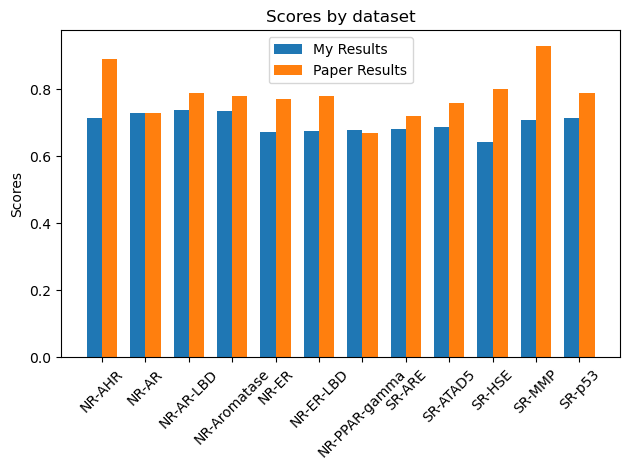

In [145]:
'''
 --> NR-AHR: 0.7142
    --> NR-AR: 0.7303
    --> NR-AR-LBD: 0.7376
    --> NR-Aromatase: 0.7371
    --> NR-ER: 0.6733
    --> NR-ER-LBD: 0.6771
    --> NR-PPAR-gamma: 0.6802
    --> SR-ARE: 0.6816
    --> SR-ATAD5: 0.6864
    --> SR-HSE: 0.6444
    --> SR-MMP: 0.7102
    --> SR-p53: 0.71344
'''
my_results={'NR-AHR':0.7142, 'NR-AR':0.7303, 'NR-AR-LBD':0.7376, 'NR-Aromatase':0.7371, 'NR-ER':0.6733, 'NR-ER-LBD':0.6771, 'NR-PPAR-gamma':0.6802, 'SR-ARE':0.6816, 'SR-ATAD5':0.6864, 'SR-HSE':0.6444, 'SR-MMP':0.7102, 'SR-p53':0.71344}
paper_results={'NR-AHR':0.89, 'NR-AR':0.73, 'NR-AR-LBD':0.79, 'NR-Aromatase':0.78, 'NR-ER':0.77, 'NR-ER-LBD':0.78, 'NR-PPAR-gamma':0.67, 'SR-ARE':0.72, 'SR-ATAD5':0.76, 'SR-HSE':0.80, 'SR-MMP':0.93, 'SR-p53':0.79}

import matplotlib.pyplot as plt
import numpy as np

labels = list(my_results.keys())
my_results_values = list(my_results.values())
paper_results_values = list(paper_results.values())

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, my_results_values, width, label='My Results')
rects2 = ax.bar(x + width/2, paper_results_values, width, label='Paper Results')

# Add some text for labels, title and custom x-axis tick labels, etc., rotate the x axis labels
ax.set_ylabel('Scores')
ax.set_title('Scores by dataset')
ax.set_xticks(x)
ax.set_xticklabels(labels,rotation=45)
ax.legend()

fig.tight_layout()

#save the figure to high resolution

fig.savefig('results.png', dpi=300)

plt.show()



In [154]:
my_paper_avg_auc=0
for key in my_results:
    my_paper_avg_auc+=my_results[key]
my_paper_avg_auc/=len(my_results)

paper_avg_auc=0
for key in paper_results:
    paper_avg_auc+=paper_results[key]
paper_avg_auc/=len(paper_results)

print(f'My average AUC: {my_paper_avg_auc}')
print(f'Paper average AUC: {paper_avg_auc}')

My average AUC: 0.6988200000000001
Paper average AUC: 0.7841666666666667


In [87]:

import torch
from sklearn.metrics import f1_score, recall_score, accuracy_score, precision_score
#area under the curve
from sklearn.metrics import roc_auc_score
import numpy as np
loss_func = torch.nn.BCEWithLogitsLoss()
test_loader = DataLoader(graphs_no_none, batch_size=16, shuffle=False)

dataset_names=df_labels.columns[1:]

results={}

for dataset_name in dataset_names:
    
    # find the nan index
    nan_index=labels_dicts[dataset_name]=='x'
    nan_index=nan_index.tolist()

    smilies_no_nan= [smilies[i] for i in range(len(smilies)) if not nan_index[i]]
    labels_no_nan= [labels_dicts[dataset_name][i] for i in range(len(labels_dicts[dataset_name])) if not nan_index[i]]
    #convert labels to int
    labels_no_nan=[int(i) for i in labels_no_nan]

    #load the model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = GNN(num_node_features=20, num_classes=1).to(device)
    # file_name=dataset_name.to_lower()
    # file_name = lower(dataset_name)

    file_name=dataset_name.lower()
    best_model_path = './Seperated_dataset/'+file_name+'/best_model.pt'
    model.load_state_dict(torch.load(best_model_path))

    print(f'Loaded model for {dataset_name}')
    print(f'pth file: {best_model_path}')   
    print("_---------------------------------")


    i=0
    for graph,label in zip(features,labels_no_nan):
        if(graph==None):
            continue    
        
        graph.y = torch.tensor(label, dtype=torch.float).view(1, -1)
    
    #remove the graphs and labels that has the graph as None. Remember to remove the None from the labels as well. labels are not None, rather the graph is None

    graphs_no_none=[]
    labels_no_none=[]
    for graph,label in zip(features,labels_no_nan):
        if(graph!=None):
            graphs_no_none.append(graph)
            labels_no_none.append(label)
    





    # Validation phase
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        val_loss = 0
        val_correct_predictions = 0
        val_total_predictions = 0
        val_all_labels = []
        val_all_predictions = []

        for data in test_loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.batch)
            loss = loss_func(out, data.y.float())
            val_loss += loss.item() * data.num_graphs

            preds = torch.round(torch.sigmoid(out))
            val_correct_predictions += (preds == data.y.float()).sum().item()
            val_total_predictions += data.y.size(0)

            val_all_labels.extend(data.y.tolist())
            val_all_predictions.extend(preds.squeeze().tolist())

        val_accuracy = val_correct_predictions / val_total_predictions
        val_avg_loss = val_loss / len(test_loader.dataset)
        # print(f'Validation Loss: {val_avg_loss:.9f}, Validation Accuracy: {val_accuracy:.4f}')

    # Calculate and print F1 and recall for training and validation sets
    f1_train = f1_score(val_all_labels, val_all_predictions)
    recall_train = recall_score(val_all_labels, val_all_predictions)
    f1_val = f1_score(val_all_labels, val_all_predictions,average='weighted')
    recall_val = recall_score(val_all_labels, val_all_predictions)
    precision= precision_score(val_all_labels, val_all_predictions)
    auc=roc_auc_score(val_all_labels, val_all_predictions)

    print(auc)

    results[dataset_name]={'f1':f1_val,'recall':recall_val,'precision':precision,'auc':auc}


    # save the results to a dictionary for each dataset
    # # print(f'Train F1 Score: {f1_train:.4f}, Train Recall: {recall_train:.4f}')
    # print(f'Validation F1 Score: {f1_val:.4f}, Validation Recall: {recall_val:.4f}, Validation Precision: {precision:.4f}, Validation AUC: {auc:.4f}')
    # # Inside our training loop, after calculating validatio







Loaded model for NR-AhR
pth file: ./Seperated_dataset/nr-ahr/best_model.pt
_---------------------------------
0.513543599257885
Loaded model for NR-AR
pth file: ./Seperated_dataset/nr-ar/best_model.pt
_---------------------------------
0.5028896346010441
Loaded model for NR-AR-LBD
pth file: ./Seperated_dataset/nr-ar-lbd/best_model.pt
_---------------------------------
0.5578571428571427
Loaded model for NR-Aromatase
pth file: ./Seperated_dataset/nr-aromatase/best_model.pt
_---------------------------------
0.5940560621411686
Loaded model for NR-ER
pth file: ./Seperated_dataset/nr-er/best_model.pt
_---------------------------------
0.4986562834020461
Loaded model for NR-ER-LBD
pth file: ./Seperated_dataset/nr-er-lbd/best_model.pt
_---------------------------------
0.501655263738689
Loaded model for NR-PPAR-gamma
pth file: ./Seperated_dataset/nr-ppar-gamma/best_model.pt
_---------------------------------
0.6119803890888229
Loaded model for SR-ARE
pth file: ./Seperated_dataset/sr-are/best

In [82]:
results

{'NR-AhR': {'f1': 0.7307475997268309,
  'recall': 0.4166666666666667,
  'precision': 0.08196721311475409,
  'auc': 0.5376016260162602},
 'NR-AR': {'f1': 0.8091552283333104,
  'recall': 0.25,
  'precision': 0.08181818181818182,
  'auc': 0.5223577235772358},
 'NR-AR-LBD': {'f1': 0.8167521052724853,
  'recall': 0.1111111111111111,
  'precision': 0.04395604395604396,
  'auc': 0.46714092140921415},
 'NR-Aromatase': {'f1': 0.7463003287475505,
  'recall': 0.5,
  'precision': 0.10112359550561797,
  'auc': 0.5873983739837398},
 'NR-ER': {'f1': 0.7976765422077923,
  'recall': 0.3055555555555556,
  'precision': 0.08870967741935484,
  'auc': 0.537940379403794},
 'NR-ER-LBD': {'f1': 0.7164021326070721,
  'recall': 0.5,
  'precision': 0.09045226130653267,
  'auc': 0.5660569105691057},
 'NR-PPAR-gamma': {'f1': 0.716546949222058,
  'recall': 0.3888888888888889,
  'precision': 0.07329842931937172,
  'auc': 0.5145663956639566},
 'SR-ARE': {'f1': 0.6452845059234573,
  'recall': 0.5555555555555556,
  'pre

In [65]:
import pandas as pd
df_results=pd.DataFrame(results)

df_results.to_csv('results.csv',index=False)

In [66]:
df_results

,NR-AhR,NR-AR,NR-AR-LBD,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53
f1,0.560165,0.544112,0.543788,0.594863,0.679033,0.690184,0.547362,0.620986,0.570590,0.561632,0.627293,0.584738
recall,0.423767,0.365471,0.358744,0.562780,0.591928,0.726457,0.455157,0.735426,0.500000,0.553812,0.695067,0.668161
precision,0.598101,0.601476,0.606061,0.601918,0.721311,0.677824,0.563889,0.602941,0.585302,0.562642,0.613861,0.575290
auc,0.569507,0.561659,0.562780,0.595291,0.681614,0.690583,0.551570,0.625561,0.572870,0.561659,0.628924,0.587444
